In [14]:
%load_ext autoreload
%autoreload 2

import itertools
import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool

from graph_generation import GenerateGraph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
import experiments
from experiments import (init_GCN, init, init_model_dataset, experiment_node_embedding, 
                         elaborate_embeddings, elaborate_embeddings_2, elaborate_embedding_pergraph, separate_embedding_by_classes,
                         run_with_weights, init_with_weights, make_video, take_corr, plot_epoch, get_corrs_training)

from config_valid import Config, TrainingMode
from GridConfigurations import GridConfigurations

import torch
from torch_geometric.loader import DataLoader
import tensorflow as tf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from plt_parameters import init_params
init_params()
#pd.set_option('display.height', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_file = "configurations/classification_cm.yml"
config_class = Config(config_file)

diz_trials = {'model.GCNneurons_per_layer' : [ [1, 16, 16, 1], 
                                             [1, 6, 6, 1],
                                             [1, 2, 2, 1]],
              #'graph_dataset.Num_grafi_per_tipo': [200, 100, 50] ,
              'model.neurons_last_linear': [[2,1], [2, 2, 1], [20, 20, 1]],
              #'training.learning_rate': [0.01, 0.005, 0.001]
              'graph_dataset.list_exponents': [[-1.01, -2.0], [-1.01, -4.5], [-4.0, -4.5], [-1.5, -2.0]]
}
#diz_trials = {'graph_dataset.Num_grafi_per_tipo': [200] ,
#              'model.neurons_last_linear': [[5,1], [3,3,1]]}

gc = GridConfigurations(config_class, diz_trials)
gc.make_configs()
for i, c in enumerate(gc.configs):
    gc.config_dataframe.loc[i, ('risultati','test_loss')] = '_'
    gc.config_dataframe.loc[i, ('risultati','test_accuracy')] = '_'
    gc.config_dataframe.loc[i, ('risultati','correlation_class0')] = '_'
    gc.config_dataframe.loc[i, ('risultati','correlation_class1')] = '_'
    
len(gc.configs)

36

In [1]:
for i, c in enumerate(gc.configs):
    print(f'Run {i+1}/{len(gc.configs)}')
    try:       
        model = init_GCN(c, verbose=False)
        #modify_parameters(model, previous_par)
        gg = GenerateGraph(c)
        dataset = gg.initialize_dataset(parallel=True)
        trainer = Trainer(model, c)
        trainer.load_dataset(dataset, percentage_train=c.conf['training']['percentage_train'], parallel=False)
        trainer.launch_training()
        
        # serve per get_corrs_training
        experiments.t = trainer
        experiments.c = c
        c_e_0, c_e_1 = get_corrs_training()
    
        gc.config_dataframe.at[i, ('risultati','test_loss')] = trainer.test_loss_list
        gc.config_dataframe.at[i, ('risultati','test_accuracy')] = trainer.accuracy_list
        gc.config_dataframe.at[i, ('risultati','correlation_class0')] = c_e_0[0]
        gc.config_dataframe.at[i, ('risultati','correlation_class1')] = c_e_1[0]
        
        #gc.config_dataframe.iloc[i:i+1].to_csv(outfile, index=False, mode='a', header=not os.path.exists(outfile))

    except Exception as e: 
        print(repr(e))


NameError: name 'gc' is not defined

In [26]:
def open_df_results(file_csv):
    df_data = pd.read_csv(file_csv, header=[0,1])
    df_data.drop(columns=['device', 'logging'], inplace=True)
    senza_loss = df_data['risultati','test_loss'] == '_'
    print(f"Erano presenti {senza_loss.sum()} righe vuote")
    df_data.drop(df_data[senza_loss].index, inplace=True)
    
    #risolve il problema dovuto a celle che contengono liste, che in lettura vengono prese come stringhe
    df_data[('model', 'GCNneurons_per_layer')] = df_data[('model', 'GCNneurons_per_layer')].apply(literal_eval)
    df_data[('model', 'neurons_last_linear')] = df_data[('model', 'neurons_last_linear')].apply(literal_eval)
    df_data[('risultati', 'test_loss')] = df_data[('risultati', 'test_loss')].apply(literal_eval)
    df_data[('risultati', 'test_accuracy')] = df_data[('risultati', 'test_accuracy')].apply(literal_eval)
    df_data[('risultati', 'correlation_class0')] = df_data[('risultati', 'correlation_class0')].apply(literal_eval)
    df_data[('risultati', 'correlation_class1')] = df_data[('risultati', 'correlation_class1')].apply(literal_eval)
    
    return df_data
df = open_df_results("df_configs_new6.csv")

Erano presenti 0 righe vuote


/tmp/ipykernel_58911/1312977622.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_data.drop(columns=['device', 'logging'], inplace=True)


In [10]:
m = gc.config_dataframe[('risultati', 'test_loss')] == '_'
gc.config_dataframe.drop(gc.config_dataframe[m].index, inplace=True)

In [12]:
diz_trials

{'model.GCNneurons_per_layer': [[1, 16, 16, 1], [1, 6, 6, 1], [1, 2, 2, 1]],
 'model.neurons_last_linear': [[2, 1], [2, 2, 1], [20, 20, 1]],
 'graph_dataset.list_exponents': [[-1.01, -2.0],
  [-1.01, -4.5],
  [-4.0, -4.5],
  [-1.5, -2.0]]}

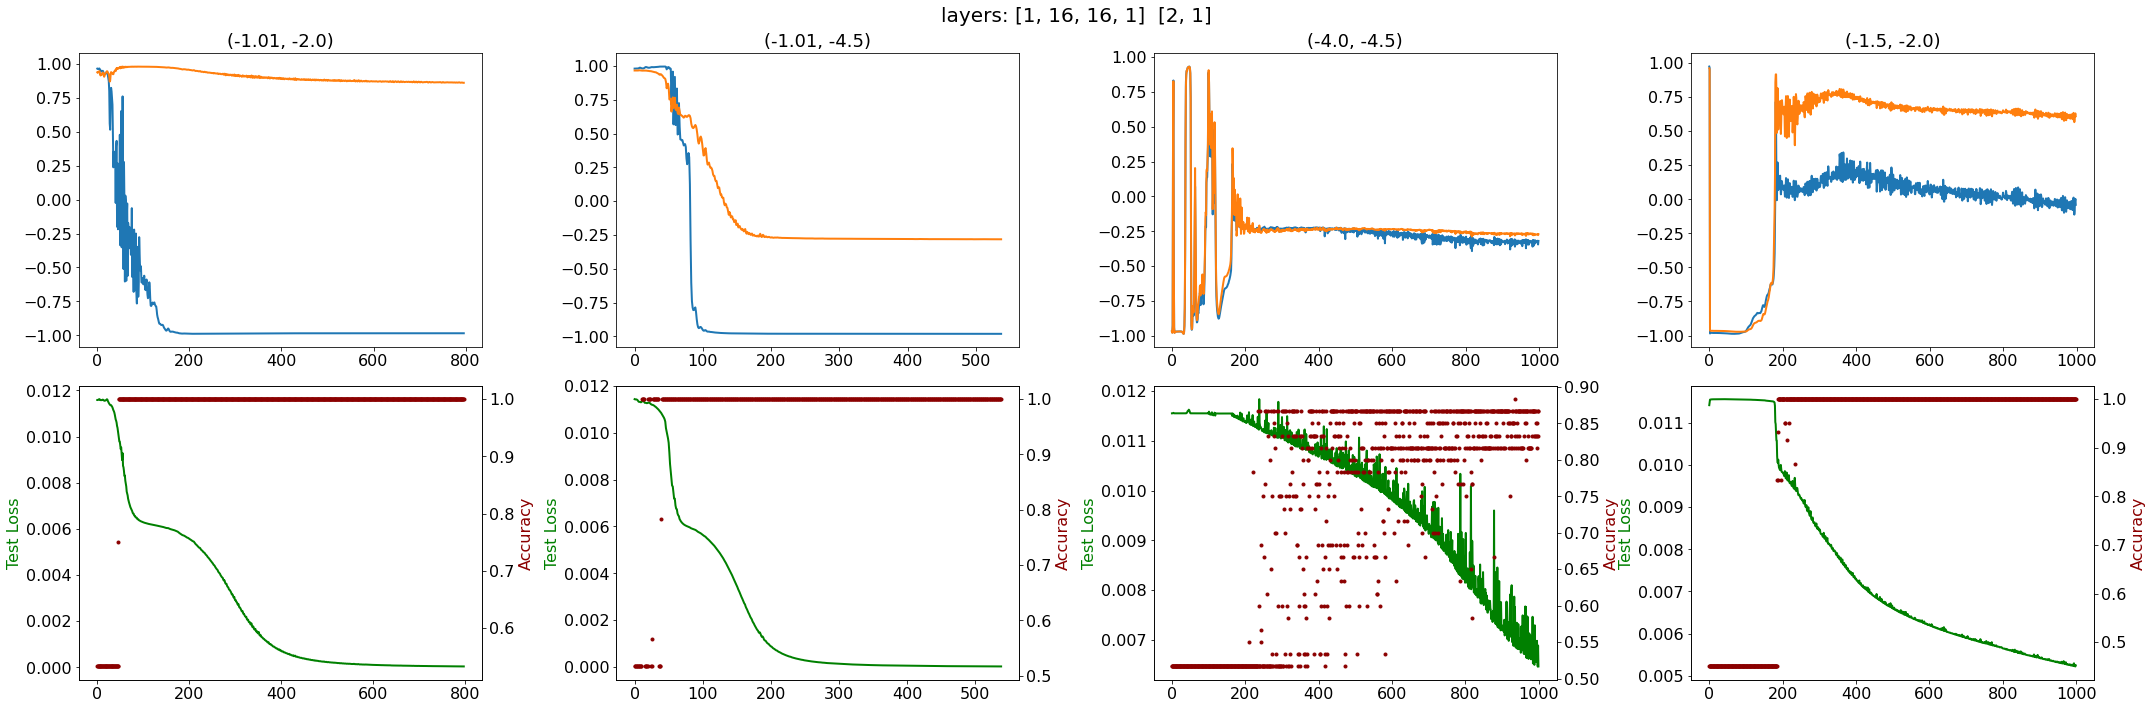

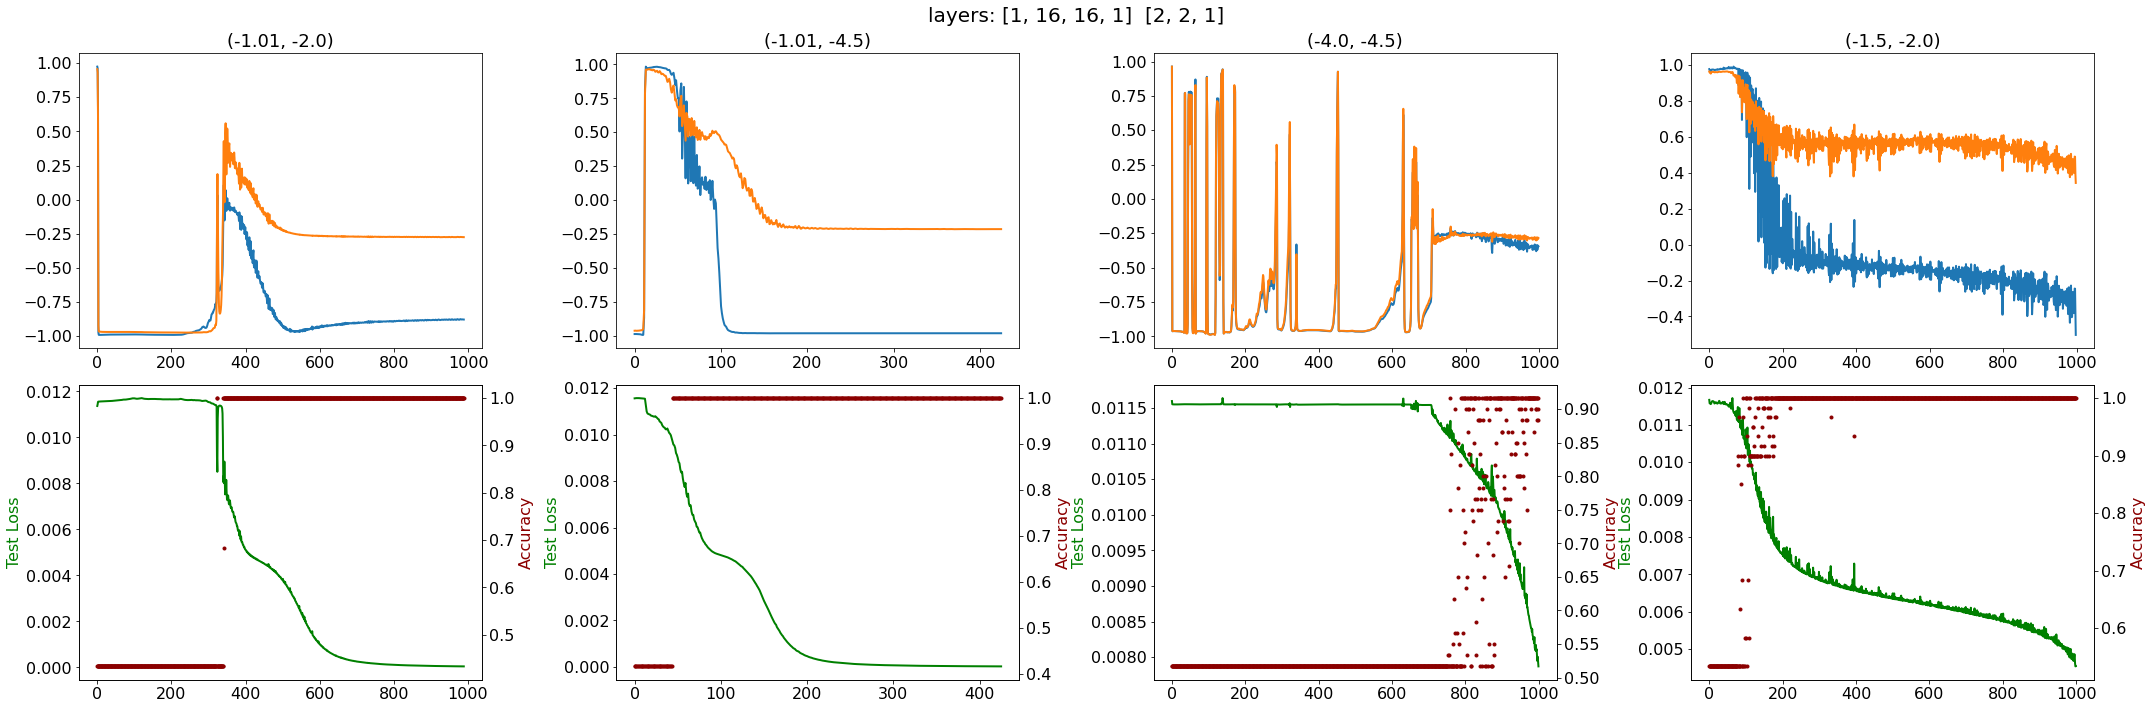

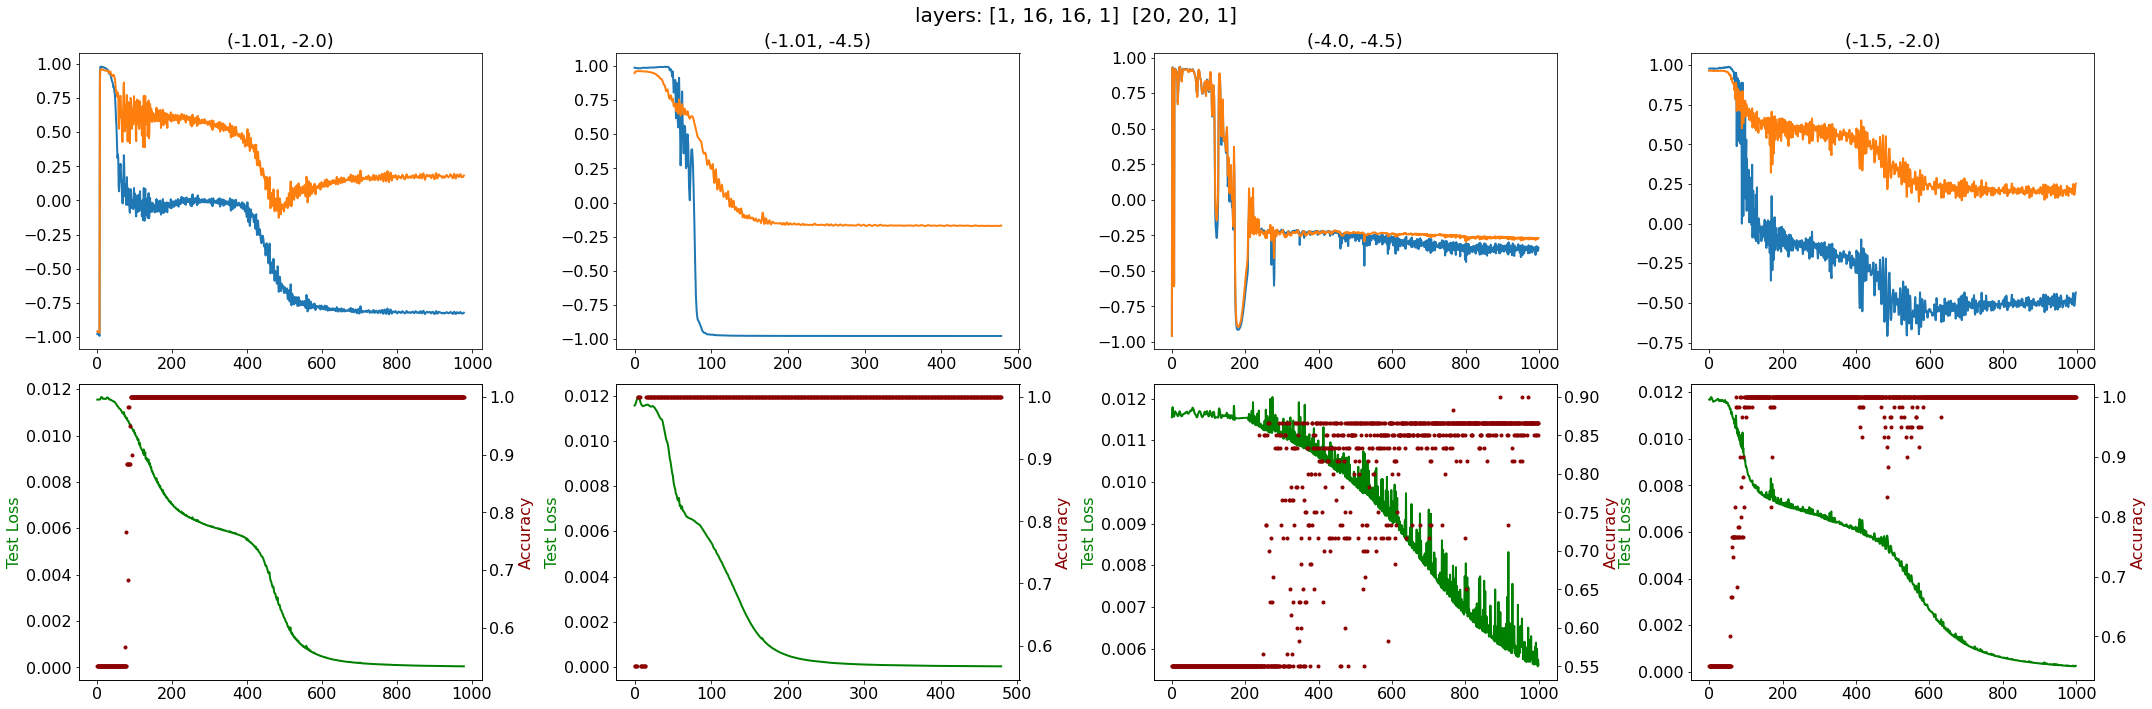

In [82]:
# seleziono un lr e vario i livelli densi
for layer1 in diz_trials['model.GCNneurons_per_layer']:
    for layer2 in diz_trials['model.neurons_last_linear']:
        m1 = df[('model', 'GCNneurons_per_layer')].isin([layer1])
        if m1.sum() > 0:
            m2 = df[('model','neurons_last_linear')].isin([tuple(layer2)])
            if m2.sum() > 0:
                res = df[m1 & m2]
                col = res.shape[0]
                fig, axs = plt.subplots(2,col,figsize=(30,10))
                for i, (j, row) in enumerate(res.iterrows()):
                    c_e_0 = row[('risultati', 'correlation_class0')]
                    axs[0][i].plot(c_e_0)
                    c_e_1 = row[('risultati', 'correlation_class1')]
                    axs[0][i].plot(c_e_1)
                    axs[0][i].set_title(res.loc[j,('graph_dataset','list_exponents')])
                    axt = axs[1][i].twinx()
                    axs[1][i].plot(row[('risultati', 'test_loss')], color='g')
                    axs[1][i].set_ylabel('Test Loss', color='g')
                    axt.plot(row[('risultati', 'test_accuracy')], '.', color='darkred')
                    axt.set_ylabel('Accuracy', color='darkred')
                plt.suptitle(f"layers: {layer1}  {layer2}")
                #plt.savefig("correlation_vs_epochs_layers_2b.png")
                plt.tight_layout()
                plt.show()

In [13]:
outfile = "df_configs_new6.csv"
gc.config_dataframe.to_csv(outfile)